# Semantic change in LatinISE


Barbara McGillivray

This notebook contains the code for detecting semantic change in the Latin corpus LatinISe using word embeddings.

## Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [1]:
!pip install gensim==4.0
!pip install plotly


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


Import libraries

In [2]:
import os 
#from bs4 import BeautifulSoup
import csv
import numpy as np
import pandas as pd
#from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
#from nltk.corpus import stopwords
#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from gensim.models import FastText
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import plotly.express as px
import re
from statistics import mean
#from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Parameters

I set the parameters of the analysis.

In [3]:
lemmas_or_tokens = "lemmas" # this can be "lemmas" or "tokens"

## Reading the files

I define the name of the folders:

In [4]:
dir_in = os.path.join("/Users", "barbaramcgillivray", "OneDrive - King's College London", "Research", "2022", "Nexus Linguarum WG4 UC4.2",  "LatinISE")
dir_out = os.path.join(dir_in, "semantic_change_output")

I define the list of all files:

In [5]:
files = os.listdir(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens))

How many files are in the folder?


In [6]:
len(files)

1268

We only want IntraText files:

In [7]:
files = [f for f in files[:] if "IT" in f]
len(files)

670

I read the metadata file:

In [8]:
metadata_df = pd.read_csv(os.path.join(dir_in, 'latinise_metadata.csv'), sep = ",")
metadata_df = metadata_df[metadata_df['id'].str.startswith("IT")]
metadata_df

,id,title,creator,date,type,file
18,IT-LAT0001,Vulgata,Hieronymus,382.0,poetry,lat_0382_IT-LAT0001.txt
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9.0,poetry,lat_-009_IT-LAT0537.txt
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524.0,prose,lat_0524_IT-LAT0011.txt
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254.0,prose,lat_1254_IT-LAT0012.txt
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254.0,poetry,lat_1254_IT-LAT0014.txt
...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_1.txt
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_2.txt
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_3.txt
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116.0,prose,lat_0116_IT-LAT0534_4.txt


In [9]:
metadata_df.shape

(670, 6)

In [10]:
metadata_df.columns

Index(['id', 'title', 'creator', 'date', 'type', 'file'], dtype='object')

In [11]:
metadata_df['date'].describe

<bound method NDFrame.describe of 18       382.0
19        -9.0
20       524.0
21      1254.0
22      1254.0
         ...  
683      116.0
684      116.0
685      116.0
686      116.0
1265     533.0
Name: date, Length: 670, dtype: float64>

In [12]:
metadata_df.dtypes

id          object
title       object
creator     object
date       float64
type        object
file        object
dtype: object

Convert date to integer

In [34]:
metadata_df['date'] = metadata_df['date'].astype(int)
metadata_df.dtypes

id               object
title            object
creator          object
date              int64
type             object
file             object
time_interval    object
dtype: object

In [35]:
metadata_df.head

<bound method NDFrame.head of                 id                          title  \
18      IT-LAT0001                        Vulgata   
19      IT-LAT0537                   Ars amatoria   
20      IT-LAT0011            S. Benedicti Regula   
21      IT-LAT0012   In psalmis Davidis expositio   
22      IT-LAT0014                Adoro te devote   
...            ...                            ...   
683   IT-LAT0534_1  De origine et situ Germanorum   
684   IT-LAT0534_2        De vita Iulii Agricolae   
685   IT-LAT0534_3         Dialogus de oratoribus   
686   IT-LAT0534_4                      Historiae   
1265    IT-LAT0202                  Institutiones   

                                                creator  date    type  \
18                                           Hieronymus   382  poetry   
19                                Ovidius Naso, Publius    -9  poetry   
20                                 Benedictus Nursianus   524   prose   
21                              Thomas Aq

Number of works per year:

In [36]:
metadata_df0 = metadata_df.groupby(['date']).count()
metadata_df0 = metadata_df0['id']
metadata_df0

date
-450     1
-229     1
-199     3
-185     1
-149     2
        ..
 2001    4
 2002    2
 2003    1
 2004    1
 2005    1
Name: id, Length: 263, dtype: int64

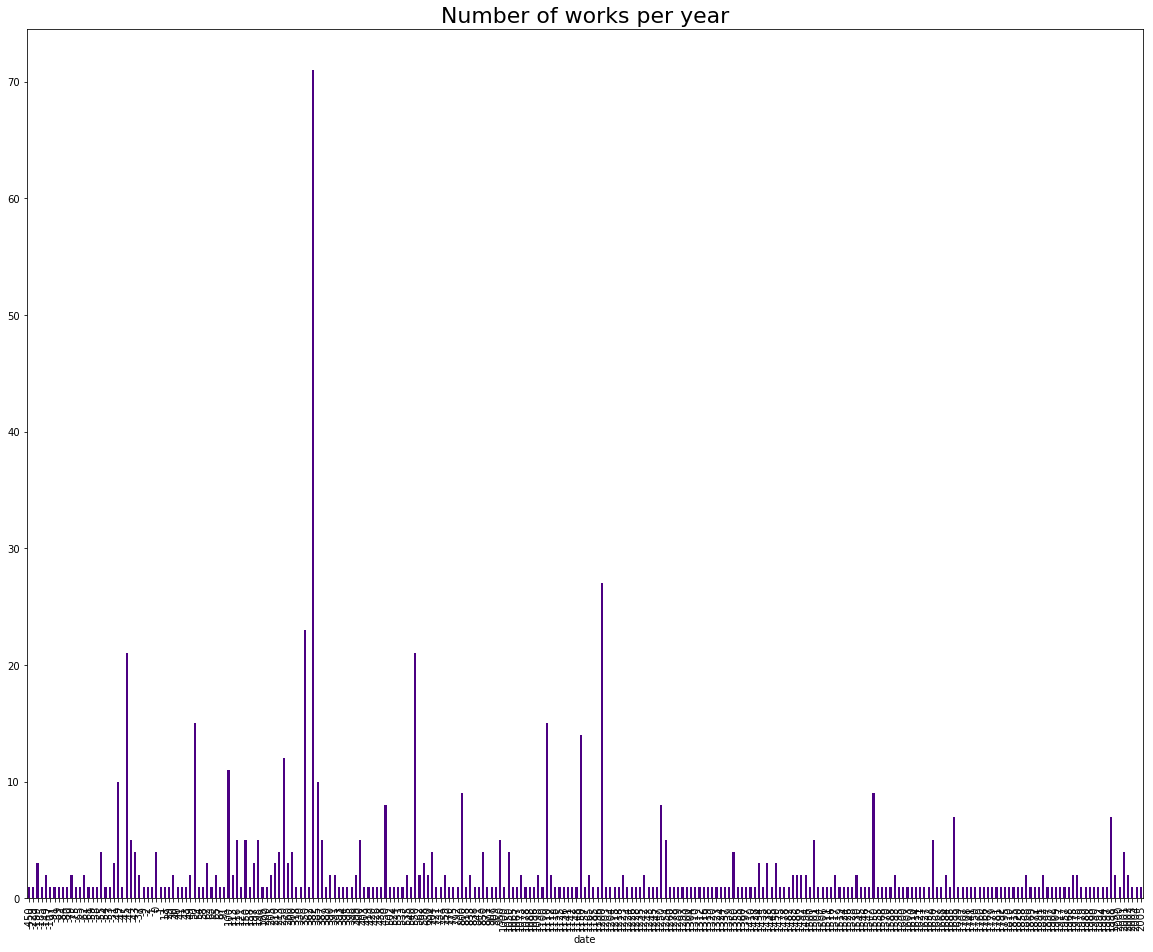

In [37]:
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per year", fontsize=22)
plt.show()

## Split the corpus into subcorpora

Find the first and last year in the dataset:

In [38]:
first_date = min(metadata_df.date)
last_date = max(metadata_df.date)
print(first_date)
print(last_date)

-450
2005


We stop at 900 CE.

In [39]:
last_date = 900

Define size of the time intervals:

In [40]:
size_interval = 450

So there are

In [41]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

3

time intervals.

Define the time periods and split the corpus:

In [42]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = int(first_date)
    else:
        intervals[t] = int(intervals[t-1]+size_interval)
    #print(intervals[t])
    
print(intervals)

[-450, 0, 450, 900]


Add a column to the metadata_df for the time interval:

In [43]:
metadata_df['time_interval'] = ""
for t in range(len(intervals)-1):
    print(t)
    print(range(intervals[t],intervals[t+1]))
    metadata_df_t = metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1]))]
    print(metadata_df_t.date)
    metadata_df.loc[metadata_df['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
metadata_df

0
range(-450, 0)
19      -9
34     -49
39     -45
42     -49
57     -80
      ... 
635   -149
638   -107
642    -37
643    -37
649   -229
Name: date, Length: 77, dtype: int64
1
range(0, 450)
18     382
23     399
24     391
37     158
38      49
      ... 
682    382
683    116
684    116
685    116
686    116
Name: date, Length: 235, dtype: int64
2
range(450, 900)
20      524
102     800
104     800
105     800
106     800
       ... 
609     598
634     550
636     550
645     450
1265    533
Name: date, Length: 73, dtype: int64


,id,title,creator,date,type,file,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,0
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,0
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0


Visualise distribution of time intervals:

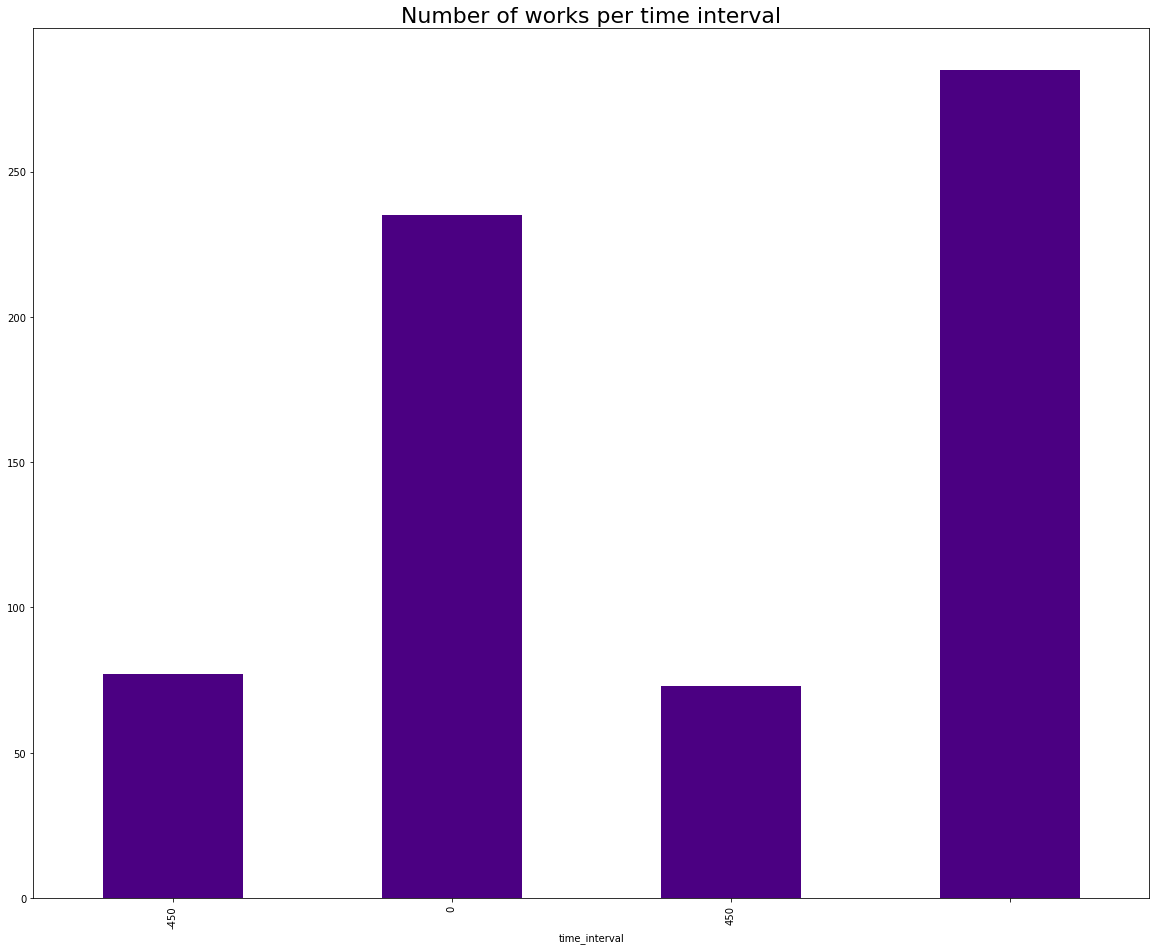

In [44]:
metadata_df0 = metadata_df.groupby(['time_interval']).count()
metadata_df0 = metadata_df0['id']
metadata_df0
ax = metadata_df0.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

We may want to do something about this inbalance. See further down for the "Historical subcorpus".

## Training embeddings for the whole corpus

Function for printing the vocabulary of a model

In [45]:
def print_vocab(model, top_n = None):
  if model == '':
    print("Empty model!")
  else:
    count = 0
    if top_n is not None:
      for index, word in enumerate(model.wv.index_to_key):
        count+= 1
        if count < top_n:
          print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
    else:
      for index, word in enumerate(model.wv.index_to_key):
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

Function that converts dates into the standard format:

In [46]:
def convert_dates(sign, date0):

    if sign == "0":
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = "+" + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = "+" + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = "+" + str(date0)
            #print("3-final_date", final_date)
    else:
        if date0 == 0:
            final_date = "+0000"
        elif date0 < 100:
            final_date = str(sign) + "00" + str(date0)
            #print("1-final_date", final_date)
        elif date0 < 1000:
            final_date = str(sign) + "0" + str(date0)
            #print("2-final_date", final_date)
        else:
            final_date = str(sign) + str(date0)
            #print("3-final_date", final_date)

    if final_date.startswith("+"):
        final_date = final_date.replace("+", "")
    return final_date

#### Stopwords exclusion and further filtering


I exclude punctuation marks:

In [47]:
punctuation = ['.', ',', '...', ';', ':', '?']

I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [48]:
corpus = list()
files_corpus = metadata_df
for index, df_line in files_corpus.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus.append(sentences_this_file)

3: lat_0382_IT-LAT0001.txt
3: lat_-009_IT-LAT0537.txt
3: lat_0524_IT-LAT0011.txt
3: lat_1254_IT-LAT0012.txt
3: lat_1254_IT-LAT0014.txt
3: lat_0399_IT-LAT0015.txt
3: lat_0391_IT-LAT0016.txt
3: lat_1224_IT-LAT0017.txt
3: lat_1150_IT-LAT0018.txt
3: lat_2000_IT-LAT0021.txt
3: lat_1517_IT-LAT0022.txt
3: lat_1547_IT-LAT0023.txt
3: lat_1530_IT-LAT0024.txt
3: lat_1260_IT-LAT0025.txt
3: lat_1250_IT-LAT0026.txt
3: lat_1998_IT-LAT0027.txt
3: lat_-0049_IT-LAT0029.txt
3: lat_2001_IT-LAT0030.txt
3: lat_1992_IT-LAT0031.txt
3: lat_0158_IT-LAT0043.txt
3: lat_0049_IT-LAT0045.txt
3: lat_-0045_IT-LAT0047.txt
3: lat_0050_IT-LAT0051.txt
3: lat_0121_IT-LAT0054.txt
3: lat_-0049_IT-LAT0056.txt
3: lat_0199_IT-LAT0058.txt
3: lat_0387_IT-LAT0061.txt
3: lat_0197_IT-LAT0062.txt
3: lat_0050_IT-LAT0563.txt
3: lat_0062_IT-LAT0071.txt
3: lat_0049_IT-LAT0072.txt
3: lat_0063_IT-LAT0073.txt
3: lat_0000_IT-LAT0075.txt
3: lat_0062_IT-LAT0078.txt
3: lat_0058_IT-LAT0079.txt
3: lat_0385_IT-LAT0574.txt
3: lat_0040_IT-LAT0083.tx

In [49]:
metadata_df

,id,title,creator,date,type,file,time_interval
18,IT-LAT0001,Vulgata,Hieronymus,382,poetry,lat_0382_IT-LAT0001.txt,0
19,IT-LAT0537,Ars amatoria,"Ovidius Naso, Publius",-9,poetry,lat_-009_IT-LAT0537.txt,-450
20,IT-LAT0011,S. Benedicti Regula,Benedictus Nursianus,524,prose,lat_0524_IT-LAT0011.txt,450
21,IT-LAT0012,In psalmis Davidis expositio,Thomas Aquinas: Sanctus,1254,prose,lat_1254_IT-LAT0012.txt,
22,IT-LAT0014,Adoro te devote,Thomas Aquinas: Sanctus,1254,poetry,lat_1254_IT-LAT0014.txt,
...,...,...,...,...,...,...,...
683,IT-LAT0534_1,De origine et situ Germanorum,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_1.txt,0
684,IT-LAT0534_2,De vita Iulii Agricolae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_2.txt,0
685,IT-LAT0534_3,Dialogus de oratoribus,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_3.txt,0
686,IT-LAT0534_4,Historiae,"Tacitus, Publius (Gaius) Cornelius",116,prose,lat_0116_IT-LAT0534_4.txt,0


In [50]:
corpus

[['in', 'principium', 'creo', 'deus', 'caelum', 'et', 'terra'],
 ['terra',
  'autem',
  'sum',
  'inanis',
  'et',
  'vacuus',
  'et',
  'tenebrae',
  'super',
  'facies',
  'abyssus',
  'et',
  'spiritus',
  'deus',
  'fero',
  'super',
  'aqua'],
 ['dico', 'deus', 'fio', 'lux', 'et', 'facio', 'sum', 'lux'],
 ['et',
  'video',
  'deus',
  'lux',
  'quod',
  'sum',
  'bonus',
  'et',
  'divisor',
  'lux',
  'atque',
  'tenebrae'],
 ['appello',
  'lux',
  'dies',
  'et',
  'tenebrae',
  'nox',
  'factumque',
  'sum',
  'vesper',
  'et',
  'mane',
  'dies',
  'unus'],
 ['dico#2',
  'quoque',
  'deus',
  'fio',
  'firmamentum',
  'in',
  'medius',
  'aqua',
  'et',
  'divido',
  'aqua',
  'ab',
  'aqua'],
 ['et',
  'facio',
  'deus',
  'firmamentum',
  'divisitque',
  'aqua',
  'quis#2',
  'sum',
  'sub',
  'firmamentum',
  'ab',
  'hic',
  'quis#2',
  'sum',
  'super',
  'firmamentum',
  'et',
  'facio',
  'sum',
  'ita'],
 ['voco',
  'deus',
  'firmamentum',
  'caelum',
  'et',
  'facio

In [51]:
len(corpus)

512576

Function for training FastText models (from Krzysztof Nowak):

In [52]:
def fasttext(self, opts=dict()):
        """
        Reads sentences from the corpus. Implements:
            https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText
        Returns
        -------
        FastText model
        """
        default_opts = dict(vector_size=100, alpha=0.025,
                            window=5, min_count=5, epochs=5)
        opts_new = default_opts
        for opt in opts.keys():
            opts_new[opt] = opts[opt]
        model = FastText(
            vector_size=opts_new["vector_size"],
            alpha=opts_new["alpha"],
            window=opts_new["window"],
            min_count=opts_new["min_count"])
        model.build_vocab(corpus_iterable=[sentence for sentence in
                                           self.corpus.get_sents()])
        total_examples = model.corpus_count
        model.train(corpus_iterable=[sentence for sentence
                                     in self.corpus.get_sents()],
                    total_examples=total_examples,
                    epochs=opts_new["epochs"])
        return model

Parameters: 

`min_count`: the minimum frequency threshold allowed for a word to be included; set to 3 following Ribary & McGillivray (2020) or 5 following Sprugnoli et al. (2019).

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000. Set to 100 following Ribary & McGillivray (2020).

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10. Set to 10 following Sprugnoli et al. (2020).

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW. Set to 10 following Ribary & McGillivray (2020).


Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [53]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

(33210810, 44714280)

Let's see what words are similar to "dies":

In [54]:
model.wv.similar_by_word('dies', 10)

[('hora', 0.7181485891342163),
 ('annus', 0.6502978801727295),
 ('mensis', 0.6495981216430664),
 ('meridies', 0.63538658618927),
 ('mensium', 0.6009042263031006),
 ('anchora', 0.5829669237136841),
 ('nox', 0.5721181631088257),
 ('ann', 0.5675910711288452),
 ('triduum', 0.5575207471847534),
 ('amphora', 0.5548365116119385)]

Let's try with different parameters:

In [56]:
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-56-91d5876c4ae9>", line 4, in <module>
    model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
  File "/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/models/word2vec.py", line 1062, in train
    trained_word_count_epoch, raw_word_count_epoch, job_tally_epoch = self._train_epoch(
  File "/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/models/word2vec.py", line 1423, in _train_epoch
    trained_word_count, raw_word_count, job_tally = self._log_epoch_progress(
  File "/Users/barbaramcgillivray/opt/anaconda3/lib/python3.8/site-packages/gensim/models/word2vec.py", line 1278, in _log_epoch_progress
    report = progress_queue.get()  # blocks if workers too slow
  File

TypeError: object of type 'NoneType' has no len()

In [ ]:
start = time.time()
model = FastText(vector_size=100, window=10, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

I experiment with two equivalent ways to train a Fast Text model:

In [ ]:
model = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash)
model.build_vocab(corpus_iterable=corpus)
model.corpus_count
model.train(corpus_iterable=corpus, total_examples=model.corpus_count, epochs=5)

In [ ]:
model2 = FastText(vector_size=100, alpha=0.025, window=1, min_count=50, workers=1, seed=1, hashfxn=hash, 
                  sentences=corpus)
model2.corpus_count

In [ ]:
np.allclose(model.wv['dies'], model2.wv['dies'])

The models has a vocabulary of

In [ ]:
model.corpus_total_words

words and 

In [ ]:
model.corpus_count

sentences.

I evaluate different configurations of the parameters for the embeddings against the gold standard set by Sprugnoli et al. (2019) (https://github.com/CIRCSE/Lemma-Embeddings-for-Latin/blob/master/syn-selection-benchmark-Latin.tsv) to find the best configuration of parameters:

https://gitlab.surrey.ac.uk/mr0048/pydigest/-/blob/master/script/fasttext_003.py

WE MAY ALSO WANT TO EVALUATE THE TIME-INSENSITIVE EMBEDDINGS (i.e. trained of the full corpus) similarly to Ribary & McGillivray (2020)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [57]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus = dict()

# I loop over all time intervals:
for t in range(n_intervals+1):
    files_corpus_t = metadata_df.loc[metadata_df['time_interval'] == intervals[t]]
    #print("1:",files_corpus_t, type(files_corpus_t))
    corpus_t = list()
    for index, df_line in files_corpus_t.iterrows():
        #print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus[t] = corpus_t


Let's inspect the corpus for the first time interval:

In [ ]:
time2corpus[0]

And the second:

In [ ]:
time2corpus[1]

And the third:

In [ ]:
time2corpus[2]

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

Start with the first subcorpus:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash)
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

In [ ]:
print_vocab(model, 10)

I now check the similar words to "sum":

In [ ]:
model.wv.similar_by_word('sum', 10)

The corpus is small and the fasttext seems to prefer orthographic similarity with smaller min_counts. We're not interested in dies being similar to rabies, but rather dies being similar to annus or mensis. So, we have two options: we may either turn off the subwords or apply high frequency threshold (but we're going to loose low-frequency terms) 

Let's try changing the parameters to exclude subwords:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

Additionally, we could set a higher frequency threshold, but that we would lose low-frequency terms:

In [ ]:
start = time.time()
#model = gensim.models.Word2Vec(time2corpus[0], min_count=5, vector_size=100, window = 10, sg = 1)
start = time.time()
model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0) 
model.build_vocab(corpus_iterable=time2corpus[0])
model.train(corpus_iterable=time2corpus[0], total_examples=model.corpus_count, epochs=5)
end = time.time()
print("It has taken", round(end - start), "seconds")
model.wv.similar_by_word('dies', 10)

In [ ]:
model.wv.similar_by_word('sum', 10)

I now train one model for each time interval:

In [ ]:
len(time2corpus)

In [ ]:
models = list()
start = time.time()
for t in range(len(time2corpus)):
    if len(time2corpus[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model = FastText(vector_size=100, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0)  # instantiate
        model.build_vocab(corpus_iterable=time2corpus[t])
        model.train(corpus_iterable=time2corpus[t], total_examples=len(time2corpus[t]), epochs=10)  # train
        models.append(model)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

Let's check some models:

In [ ]:
print_vocab(models[0], 20)

In [ ]:
models[0].wv.similar_by_word('dies', 10)

In [ ]:
print_vocab(models[1], 20)

In [ ]:
models[1].wv.similar_by_word('dies', 10)

In [ ]:
models[2].wv.similar_by_word('dies', 10)

##  Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords https://github.com/williamleif/histwords.

First, I define a function to find the intersection between the vocabularies of two word2vec models:



In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (common_vocab, m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    print(common_vocab)
    print(m1)
    print(m2)
    return (common_vocab, m1, m2)

Then, I define a function for aligning two spaces with Orthogonal Procrustes:

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    common_vocab, in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # re-filling the normed vectors: the following two lines were added following Japleen Gulati, following amacanovic's comments in the discussion below this page: https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8

    in_base_embed.wv.fill_norms(force=True)
    in_other_embed.wv.fill_norms(force=True)
    
    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed


Now I can apply the function to my models:

In [ ]:
smart_procrustes_align_gensim(models[2], models[0])

I align all models:

In [ ]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models)-1):
    reduce(smart_procrustes_align_gensim, models)
    

Now the models have been aligned and have the same vocabulary:

In [ ]:
for i in range(0,len(models)):
    print(i, len(models[i].wv.index_to_key))

# Semantic change with cosine similarity

In [ ]:
intervals

In [ ]:
models

I define a function that, given a reference step (either "first" or "last), it returns the time intervals' range to be used to compare models against this reference step:

In [ ]:
def find_reference_intervals(reference_step, intervals):
    
    if reference_step == "first":
        #range_intervals = range(intervals[1], intervals[len(intervals)-1], size_interval)
        #range_intervals_index = range(1, len(intervals)-1)
        #reference_interval = intervals[0]
        reference_interval_index = 0
    elif reference_step == "last":
        #range_intervals = range(intervals[0], intervals[len(intervals)-2], size_interval)
        #range_intervals_index = range(0, len(intervals)-2)
        #reference_interval = intervals[len(intervals)-1]
        reference_interval_index = len(intervals)-2
        
    #return (range_intervals, range_intervals_index, reference_interval, reference_interval_index)
    return reference_interval_index

In [ ]:
find_reference_intervals("first", intervals)

In [ ]:
find_reference_intervals("last", intervals)

Let's define a function that calculates the cosine similarity between the embedding of a word in a time interval t and the embedding of the same word in the reference time interval:

In [ ]:
def cosine_similarity(word, t, reference_step, models, intervals):
    #(range_intervals, range_intervals_index, reference_interval, reference_interval_index)= find_reference_intervals(reference_step)
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    sc = np.nan
    if models[reference_interval_index] == '':
        print("Model of reference interval is empty!")
    else:
        if models[t] != '':
            #print(t, word)
            sc = 1-spatial.distance.cosine(models[t].wv[word], models[reference_interval_index].wv[word])
    return sc

In [ ]:
cosine_similarity("sum", 2, "last", models, intervals)

In [ ]:
cosine_similarity("sum", 2, "first", models, intervals)

Now I define a function that, given a reference step and a time interval index (starting from 0 for the first model), calculates the semantic similarity for all words in the vocabulary between these two time intervals, and stores this in the dataframe cosine_similarity_df:

In [ ]:
def cosine_similarity_dataframe(reference_step, time_interval_index, models, intervals):
    if time_interval_index<0 or time_interval_index>len(models)-1:
        print("Second argument needs to be between 0 and ", len(models)-1)
        
    reference_interval_index = find_reference_intervals(reference_step, intervals)
    #print(reference_interval_index)
    if models[reference_interval_index] != '' and models[time_interval_index] != '':
        cosine_similarity_df = pd.DataFrame(([w, 
            models[reference_interval_index].wv.get_vecattr(w, "count"),
            models[time_interval_index].wv.get_vecattr(w, "count"),
            cosine_similarity(w,time_interval_index, reference_step, models, intervals)  
            ] for w in models[time_interval_index].wv.index_to_key), 
        columns = ('Word', "Frequency_t_reference-"+str(reference_step), "Frequency_t"+str(time_interval_index), 
        'Cosine_similarity(w_t_reference-'+str(reference_step)+',w_t'+str(time_interval_index)+')'))
    else:
        print("The reference model or the current model are empty!")
        cosine_similarity_df = pd.DataFrame()
    return cosine_similarity_df

In [ ]:
cosine_similarity_dataframe("last", 0, models, intervals)

In [ ]:
cosine_similarity_dataframe("last", 1, models, intervals)

Visualise the distribution of the semantic similarity scores with a histogram:

In [ ]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("last", 0, models, intervals).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [ ]:
intervals

In [ ]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(reference_step, reference_interval_index, models, intervals)
time_series_df[df.columns[0]] = df.iloc[:,0]
time_series_df[df.columns[1]] = df.iloc[:,1]
for i in range(len(models)):
    #print(reference_interval_index)
    print("Interval", str(intervals[i]), "with", str(list(intervals)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models, intervals)
#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    if i != reference_interval_index:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
        #print(time_series_df)
    else:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    
time_series_df

Print to a file:

In [ ]:
time_series_df.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_allwords.csv'), index=None)

In [ ]:
time_series_df.columns

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']]

In [ ]:
time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']].describe

In [ ]:
time_series_df[['interval-1', 'Cosine_similarity(w_t_reference-last,w_t1)']]

In [ ]:
time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
               ]].iloc[0]

In [ ]:
px.line(time_series_df[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [ ]:
plt.scatter([0,1], 
            time_series_df[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [ ]:
time_series_df.columns

In [ ]:
time_series_df

In [ ]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1 = pd.DataFrame()
for index, row in time_series_df.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1 = pd.concat([time_series_df1, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1)

time_series_df1.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1

Print to output file:

In [ ]:
time_series_df1.to_csv(os.path.join(dir_out, 'semantic_change1_'+str(size_interval)+'_allwords.csv'), index=None) 

List of socio-political terms:

In [ ]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [ ]:
time_series_df_socpol = time_series_df[time_series_df['Word'].isin(socio_political_terms)]
time_series_df_socpol.to_csv(os.path.join(dir_out, 'semantic_change_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol

In [ ]:
time_series_df1_socpol = time_series_df1[time_series_df1['Word'].isin(socio_political_terms)]
time_series_df1_socpol.to_csv(os.path.join(dir_out, 'semantic_change1_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol

In [ ]:
time_series_df1_socpol.dtypes

In [ ]:
time_series_df1_socpol["Time_interval"] = pd.to_numeric(time_series_df1_socpol["Time_interval"], downcast='integer')

In [ ]:
time_series_df1_socpol["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol["Cosine_sim"], downcast='float')

In [ ]:
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol[['Time_interval']].iloc[i], 
            time_series_df1_socpol[['Cosine_sim']].iloc[i])
plt.show()

In [ ]:
import seaborn as sns
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol, hue='Word', legend="full")
plt.show()

## Historiography subcorpus

I select by time period before 800CE and historical genre:

In [ ]:
selected_texts = ['LAT0142', 'LAT0241', 'LAT0529', 'LAT0172', 'LAT0123', 'LAT0134', 'LAT0849', 'LAT0148', 'LAT0325', 'LAT0278', 'LAT1040', 'LAT1042', 'LAT0111', 'LAT0054', 'LAT0201', 'LAT0896', 'LAT0959', 'LAT0115', 'LAT0612', 'LAT0776', 'LAT0850', 'LAT0886', 'LAT0121', 'LAT0726', 'LAT0878', 'LAT0768', 'LAT0410', 'LAT0791', 'LAT0196', 'LAT0906', 'LAT0783', 'LAT0909']
selected_texts = ['IT-'+f for f in selected_texts]
selected_texts

In [ ]:
len(selected_texts)

In [ ]:
#metadata_df_sel = pd.read_csv(os.path.join(dir_in, 'Metadata_selected_corpus.csv'), sep = ",")
#metadata_df_sel = metadata_df_sel[(metadata_df_sel['Selected for our study (1 or 0)'] == 1)
#                          & (metadata_df_sel['historical texts'] == 1)]
metadata_df_sel  = metadata_df[(metadata_df['id'].isin(selected_texts))]
metadata_df_sel.shape

In [ ]:
metadata_df_sel

Define size of the time intervals:

In [ ]:
size_interval = 450

So there are

In [ ]:
n_intervals = round((last_date-first_date)/size_interval)
n_intervals

time intervals.

In [ ]:
intervals = [None]*(n_intervals+1)
for t in range(n_intervals+1):
    #print(t)
    if t == 0:
        intervals[t] = first_date
    else:
        intervals[t] = intervals[t-1]+size_interval
    #print(intervals[t])
    
print(intervals)

Add a column to the metadata_df for the time interval:

In [ ]:
metadata_df_sel['time_interval'] = ""
for t in range(len(intervals)-1):
    #print(t)
    #print(range(intervals[t],intervals[t+1]))
    metadata_df_sel_t = metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1]))]
    #print(metadata_df_sel_t.date)
    metadata_df_sel.loc[metadata_df_sel['date'].isin(range(intervals[t],intervals[t+1])),'time_interval'] = intervals[t]
    #print(intervals[t])
metadata_df_sel

In [ ]:
metadata_df_sel.describe

Visualise distribution of time intervals:

In [ ]:
metadata_df0_sel = metadata_df_sel.groupby(['time_interval']).count()
metadata_df0_sel = metadata_df0_sel['id']
metadata_df0_sel
ax = metadata_df0_sel.plot(kind='bar', figsize=(20,16), color="indigo", fontsize=10);
#ax.set_alpha(0.5)
ax.set_title("Number of works per time interval", fontsize=22)
plt.show()

There are:

In [ ]:
n_intervals_sel = round((max(metadata_df_sel['time_interval'])-min(metadata_df_sel['time_interval']))/size_interval)
n_intervals_sel

in the historical subcorpus.

## Training embeddings for the whole subcorpus

#### Stopwords exclusion and further filtering


I create a list of lists, containing the tokens of each sentence in the whole corpus:

In [ ]:
corpus_sel = list()
files_corpus_sel = metadata_df_sel
for index, df_line in files_corpus_sel.iterrows():
    #print("line:",df_line['id'], df_line['time_interval'])
    sign = "+"
    #print(df_line['date'])
    if df_line['date'] < 0:
        sign = "-"
    #print("date:", convert_dates(sign, abs(df_line['date'])))
    file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
    #print("3:",file_name)
    file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
    sentences_this_file = list()
    while True:
        line = file.readline().strip()
        if line != "":
            #sentences_this_file.append(line.split(" "))
            #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
            corpus_sel.append([token for token in line.split(" ") if token not in punctuation])
        # if line is empty end of file is reached
        if not line:
            break
    file.close()
corpus_sel.append(sentences_this_file)

In [ ]:
corpus_sel

In [ ]:
metadata_df_sel

In [ ]:
metadata_df_sel.shape

In [ ]:
metadata_df_sel.describe

Train FastText embeddings and, for full reproducibility, limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling:

In [ ]:
start = time.time()
model_sel = FastText(vector_size=100, alpha=0.025, window=5, min_count=50, workers=1, seed=1, hashfxn=hash, max_n=0, 
                  sentences=corpus_sel)
end = time.time()
print("It has taken", round(end - start), "seconds")

Let's see what words are similar to "dies":

In [ ]:
model_sel.wv.similar_by_word('dies', 10)

## Training embeddings for each time interval

For each time interval, I read the texts from files and create a list of lists, i.e. a list of sentences:

In [ ]:
intervals_sel = [None]*(n_intervals_sel+1)
for t in range(n_intervals_sel+1):
    print(t)
    if t == 0:
        intervals_sel[t] = min(metadata_df_sel['time_interval'])
    else:
        intervals_sel[t] = intervals_sel[t-1]+size_interval
    print(intervals_sel[t])
    
print(intervals_sel)

In [ ]:
# dictionary that maps a time interval with the list of sentences of texts in that time interval"
time2corpus_sel = dict()

# I loop over all time intervals:
for t in range(n_intervals_sel+1):
    files_corpus_sel_t = metadata_df_sel.loc[metadata_df_sel['time_interval'] == intervals_sel[t]]
    print("1:",t, intervals_sel[t], "\n", files_corpus_sel_t, type(files_corpus_t))
    corpus_sel_t = list()
    for index, df_line in files_corpus_sel_t.iterrows():
        print("line:",df_line['id'], df_line['time_interval'])
        sign = "+"
        #print(df_line['date'])
        if df_line['date'] < 0:
            sign = "-"
        #print("date:", convert_dates(sign, abs(df_line['date'])))
        file_name = 'lat_'+str(convert_dates(sign, abs(df_line['date'])))+"_"+str(df_line['id'])+'.txt'
        #print("3:",file_name)
        file = open(os.path.join(dir_in, "preprocessed_"+lemmas_or_tokens, file_name), 'r')
        sentences_this_file = list()
        while True:
            line = file.readline().strip()
            if line != "":
                #sentences_this_file.append(line.split(" "))
                #sentences_this_file.append([token for token in line.split(" ") if token not in punctuation])
                corpus_sel_t.append([token for token in line.split(" ") if token not in punctuation])
            # if line is empty end of file is reached
            if not line:
                break
        file.close()
        #corpus_t.append(sentences_this_file)
    #corpus_t1
    #print(len(corpus_t1[0]))
    time2corpus_sel[t] = corpus_sel_t


In [ ]:
time2corpus_sel

Let's inspect the corpus for the first time interval:

In [ ]:
time2corpus_sel[0]

And the second:

In [ ]:
time2corpus_sel[1]

And another one:

In [ ]:
time2corpus_sel[2]

Following the findings of Sprugnoli et al. (2019) and Ribary & McGillivray (2020), for each time interval I train a fasttext model:

In [ ]:
len(time2corpus_sel)

In [ ]:
models_sel = list()
start = time.time()
for t in range(len(time2corpus_sel)):
    if len(time2corpus_sel[t])>0:
        print(t)
        #model = gensim.models.Word2Vec(time2corpus[0][0], min_count=1, vector_size=300, window = 5, sg = 0)
        model_sel = FastText(vector_size=100, window=5, min_count=5, workers=1, seed=1,hashfxn=hash, max_n=0)  # instantiate
        model_sel.build_vocab(corpus_iterable=time2corpus_sel[t])
        model_sel.train(corpus_iterable=time2corpus_sel[t], total_examples=len(time2corpus_sel[t]), epochs=10)  # train
        models_sel.append(model_sel)
        #model = fasttext.train_unsupervised(time2corpus[0][0], model='skipgram')
    else:
        models_sel.append("")
end = time.time()
print("It has taken", round(end - start), "seconds, or ", round((end - start)/60), "minutes")

Let's check some models:

In [ ]:
print_vocab(models_sel[0], 20)

In [ ]:
print_vocab(models_sel[2], 20)

In [ ]:
models_sel[0].wv.similar_by_word('dies', 10)

In [ ]:
models_sel[1].wv.similar_by_word('dies', 10)

In [ ]:
models_sel[2].wv.similar_by_word('dies', 10)

##  Embedding space alignment

I align all models:

In [ ]:
from functools import reduce
#for t in range(len(models)):
#    smart_procrustes_align_gensim(models[t], models[0], words=None)
for i in range(0,len(models_sel)-1):
    reduce(smart_procrustes_align_gensim, [m for m in models_sel if m != ''])
    

Now the models have been aligned and have the same vocabulary:

In [ ]:
for i in range(0,len(models_sel)):
    if models_sel[i] != '':
        print(i, len(models_sel[i].wv.index_to_key))

# Semantic change with cosine similarity

In [ ]:
intervals_sel

In [ ]:
models_sel

In [ ]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index

In [ ]:
models_sel[2].wv["sum"]

In [ ]:
reference_interval_index = find_reference_intervals("last", intervals_sel)
reference_interval_index
#cosine_similarity("sum", 4, "last", models_sel)

In [ ]:
cosine_similarity("sum", 2, "first", models_sel, intervals_sel)

In [ ]:
models_sel

In [ ]:
cosine_similarity_dataframe("last", 0, models_sel, intervals_sel)

In [ ]:
cosine_similarity_dataframe("first", 2, models_sel, intervals_sel)

Visualise the distribution of the semantic similarity scores with a histogram:

In [ ]:
#hist = cosine_similarity_df['Cosine_similarity(w_t0,w_t1)'].hist()
# I display the last column of the data frame:
hist = cosine_similarity_dataframe("first", 2, models_sel, intervals_sel).iloc[:,-1].hist()

Now I can store the full time series of the cosine similarity between the embedding of a word in each time interval and the embedding of that same word in the reference interval (set to "last"):

In [ ]:
intervals

In [ ]:
reference_step = "last"
time_series = list()
reference_interval_index = find_reference_intervals(reference_step, intervals)
time_series_df_sel = pd.DataFrame()
#for w in models[reference_interval_index].wv.index_to_key:
df = cosine_similarity_dataframe(reference_step, reference_interval_index, models_sel, intervals_sel)
time_series_df_sel[df.columns[0]] = df.iloc[:,0]
time_series_df_sel[df.columns[1]] = df.iloc[:,1]
for i in range(len(models_sel)):
    #print(reference_interval_index)
    print("Interval", str(intervals_sel[i]), "with", str(list(intervals_sel)[reference_interval_index]))
    df = cosine_similarity_dataframe(reference_step, i, models_sel, intervals_sel)
#    if i == reference_interval_index:
#        time_series_df = df
#        col_i = "interval-"+str(reference_interval_index)
#        time_series_df[col_i] = [reference_interval_index for w in models[reference_interval_index].wv.index_to_key]
#        col_n = "neighbours_ref-"+reference_step
#        time_series_df[col_n] = [models[reference_interval_index].wv.similar_by_word(w, 10) for w in models[reference_interval_index].wv.index_to_key]
#    else:
#        #time_series_df = time_series_df, df.iloc[:,-2:]
#        tmp_df = df.iloc[:,-2:]
#        #df.iloc[:,-2:].column[0]
#        #print(tmp_df.iloc[:,0])
#        time_series_df[tmp_df.columns[0]] = tmp_df.iloc[:,0]
#        time_series_df[tmp_df.columns[1]] = tmp_df.iloc[:,1]
#        col_i = "interval-"+str(i)
#        time_series_df[col_i] = [i for w in models[reference_interval_index].wv.index_to_key]
#        #Finding top 10 nearest neighbours:
#        col_n = "neighbours_t"+str(i)
#        time_series_df[col_n] = [models[i].wv.similar_by_word(w, 10) for w in models[i].wv.index_to_key]
    if i != reference_interval_index:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df_sel[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df_sel[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df_sel[col_i] = [i for w in models_sel[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df_sel[col_n] = [models_sel[i].wv.similar_by_word(w, 10) for w in models_sel[i].wv.index_to_key]
        #print(time_series_df)
    else:
        tmp_df = df.iloc[:,-2:]
        #df.iloc[:,-2:].column[0]
        #print(df.iloc[:,0])
        time_series_df_sel[tmp_df.columns[0]] = tmp_df.iloc[:,0]
        time_series_df_sel[tmp_df.columns[1]] = tmp_df.iloc[:,1]
        col_i = "interval-"+str(i)
        time_series_df_sel[col_i] = [i for w in models_sel[reference_interval_index].wv.index_to_key]
        #Finding top 10 nearest neighbours:
        col_n = "neighbours_t"+str(i)
        time_series_df_sel[col_n] = [models_sel[i].wv.similar_by_word(w, 10) for w in models_sel[i].wv.index_to_key]
    
time_series_df_sel

Print to a file:

In [ ]:
time_series_df_sel.to_csv(os.path.join(dir_out, 'semantic_change_histcorpus_'+str(size_interval)+'_allwords.csv'), index=None)

In [ ]:
px.line(time_series_df_sel[['interval-0', 'Cosine_similarity(w_t_reference-last,w_t0)']], 
        x = 'interval-0', y = 'Cosine_similarity(w_t_reference-last,w_t0)')

In [ ]:
plt.scatter([0,1], 
            time_series_df_sel[['Cosine_similarity(w_t_reference-last,w_t0)',
                           'Cosine_similarity(w_t_reference-last,w_t1)'
                           ]].iloc[0])
plt.show()

I rearrange the dataframe for visualization:

In [ ]:
time_series_df_sel.columns

In [ ]:
time_series_df_sel

In [ ]:
#time_series_df1 = pd.DataFrame(columns=['Time_interval', 'Cosine_sim', 'Word'])
time_series_df1_sel = pd.DataFrame()
for index, row in time_series_df_sel.iterrows():
    #print(row['interval-0'], row['Cosine_similarity(w_t_reference-last,w_t0)'])
    
    #temp = pd.DataFrame(
    #    {
    #        'Time_interval': row['interval-0'],
    #        'Cosine_sim': row['Cosine_similarity(w_t_reference-last,w_t0)'],
    #        'Word': row['Word']
    #    }
    #)
    #print([row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']])
    #print(pd.DataFrame(
    #    [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]))
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-0'],row['Cosine_similarity(w_t_reference-last,w_t0)'],row['Word']]).transpose()])
    time_series_df1_sel = pd.concat([time_series_df1_sel, pd.DataFrame(
        [row['interval-1'],row['Cosine_similarity(w_t_reference-last,w_t1)'],row['Word']]).transpose()])
    #print(time_series_df1_sel)

time_series_df1_sel.columns = ['Time_interval', 'Cosine_sim', 'Word']
time_series_df1_sel

Print to output file:

In [ ]:
time_series_df1_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_allwords.csv'), index=None) 

List of socio-political terms:

In [ ]:
socio_political_terms = ["civitas", "consilium", "consul", "dux", "gens", "hostis", "imperator", "jus", "labor", "natio", "nobilitas", "pontifex", "pontificium", "populus", "potestas", "regnum", "senatus", "sodes", "urbs"]

In [ ]:
time_series_df_socpol_sel = time_series_df_sel[time_series_df_sel['Word'].isin(socio_political_terms)]
time_series_df_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df_socpol_sel

In [ ]:
time_series_df1_socpol_sel = time_series_df1_sel[time_series_df1_sel['Word'].isin(socio_political_terms)]
time_series_df1_socpol_sel.to_csv(os.path.join(dir_out, 'semantic_change1_histcorpus_'+str(size_interval)+'_socpolwords.csv'), index=None) 
time_series_df1_socpol_sel

In [ ]:
time_series_df1_socpol_sel.dtypes

In [ ]:
time_series_df1_socpol_sel["Time_interval"] = pd.to_numeric(time_series_df1_socpol_sel["Time_interval"], downcast='integer')

In [ ]:
time_series_df1_socpol_sel["Cosine_sim"] = pd.to_numeric(time_series_df1_socpol_sel["Cosine_sim"], downcast='float')

In [ ]:
for i in range(len(socio_political_terms)):
    plt.scatter(time_series_df1_socpol_sel[['Time_interval']].iloc[i], 
            time_series_df1_socpol_sel[['Cosine_sim']].iloc[i])
plt.show()

In [ ]:
import seaborn as sns
#sns.lmplot('Time_interval', 'Cosine_sim', data=time_series_df_socpol, hue='Word', fit_reg=False)
sns.lineplot(x='Time_interval', y='Cosine_sim', data=time_series_df1_socpol_sel, hue='Word', legend="full")
plt.show()